In [1]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("../graphs.mplstyle")
from music21 import *
import pickle
import pandas as pd

from boundaryDetection import identifyBoundaries
from colours import Viridis as V

In [2]:
identifier = "opus74"

excerpt = converter.parse(f"../Pickles/{identifier}_excerpt.xml")
phraseStack = pickle.load(open(f"../Pickles/{identifier}_phraseStack.pkl", "rb"))
flatStack = [phrase for phrases in phraseStack for phrase in phrases]
SimpleG = pickle.load(open(f"../Pickles/{identifier}_simpleGraph.pkl", "rb"))
ObjectG = pickle.load(open(f"../Pickles/{identifier}_objectGraph.pkl", "rb"))
df = pickle.load(open(f"../Pickles/{identifier}_df.pkl", "rb"))

sample = df["sample"][0]
chosen = [x for x in sample if sample[x] == 1]

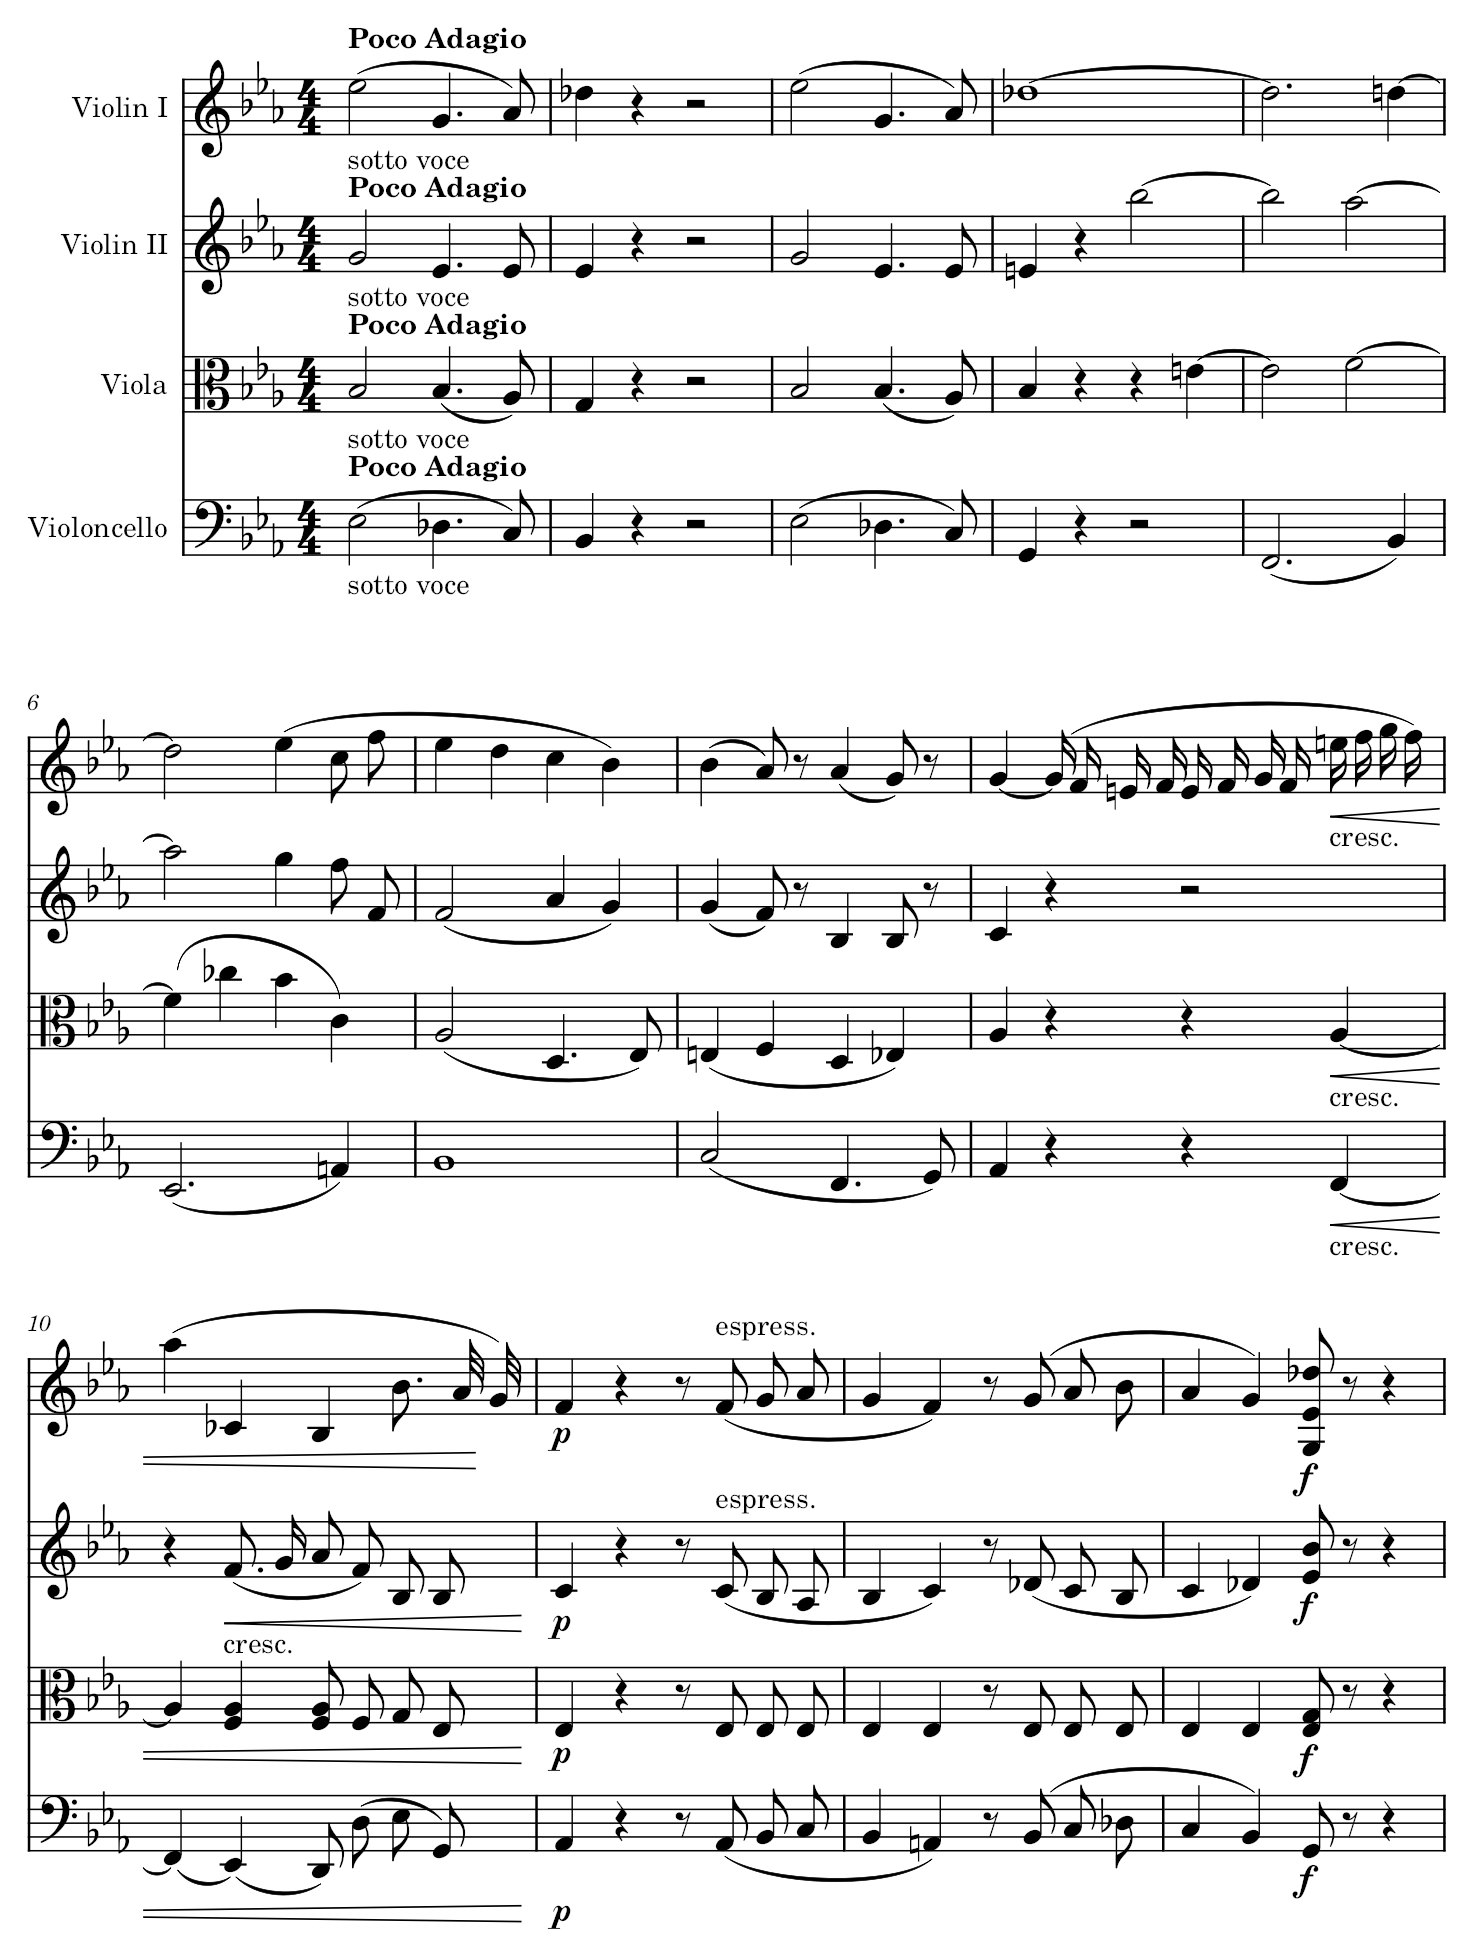

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/excerpt-1.png')

In [6]:
excerpt.metadata = metadata.Metadata()
excerpt.metadata.title = ""
excerpt.metadata.composer = ""
excerpt.show(leaveMargin=50)
excerpt.write(fmt="musicxml.png", fp="../Figures/excerpt_trim.png", dpi=300)
excerpt.write(fmt="musicxml.png", fp="../Figures/excerpt.png", dpi=300, leaveMargin=50)

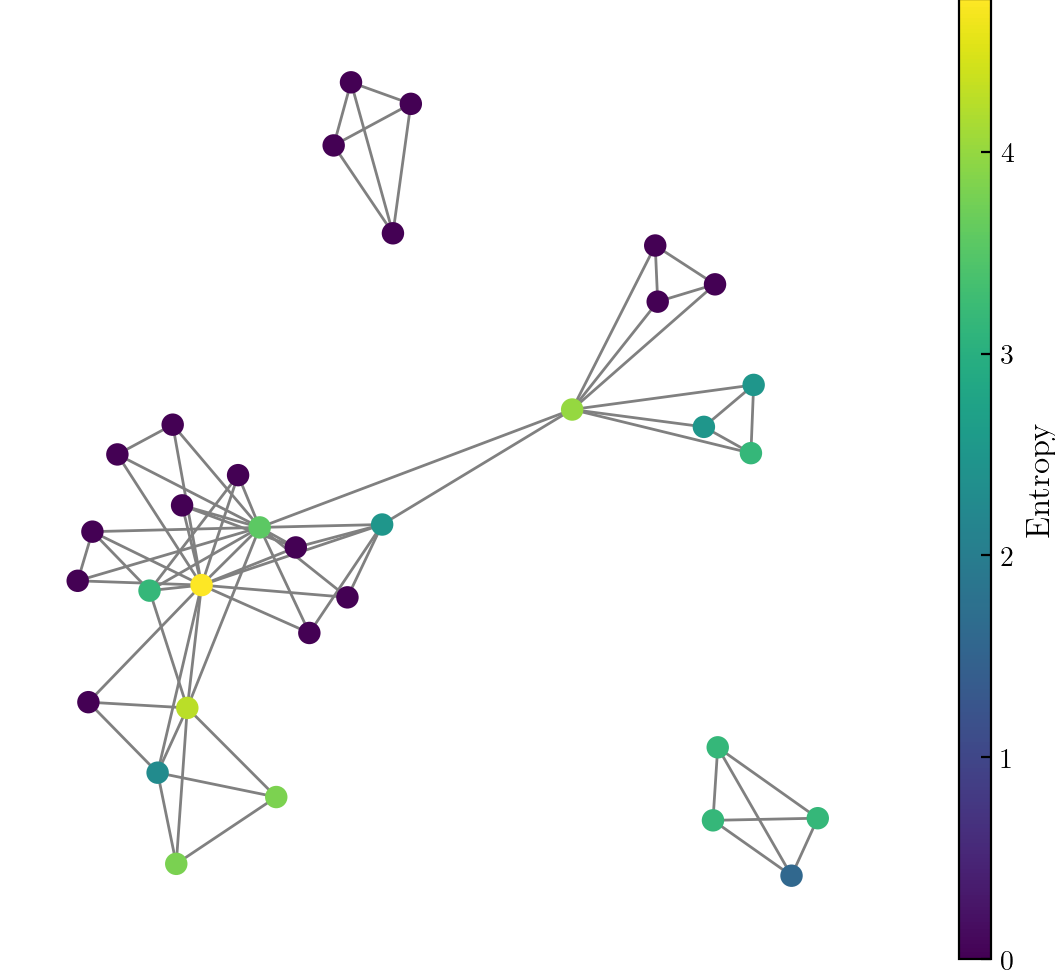

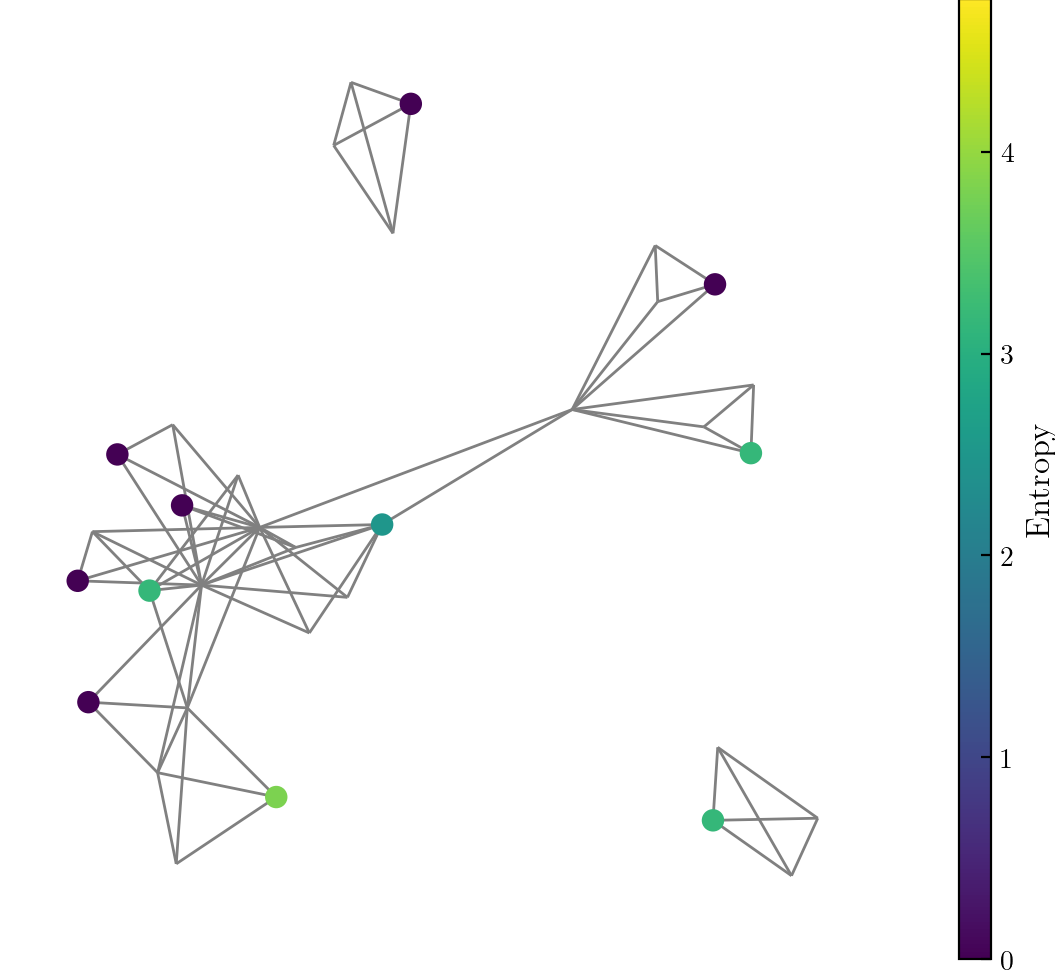

In [16]:
# Draw graphs

for n in ObjectG.nodes:
    if n.id in chosen:
        n.sol = 1
    else:
        n.sol = 0

cmap = mpl.colormaps['viridis']
nodeSize = 50
edgeColor = "grey"
edgeWidth = 1

pos = nx.spring_layout(ObjectG, k=0.5, seed=9)

plt.figure(0)
nx.draw(ObjectG, pos, nodelist=[], edge_color=edgeColor, width=edgeWidth)
pc0 = nx.draw_networkx_nodes(ObjectG, pos, node_color=[n.entropy for n in ObjectG], cmap=cmap, node_size=nodeSize)
cb = plt.colorbar(pc0, label="Entropy", aspect=30)
plt.gca().set_aspect('equal', "box")

plt.figure(1)
nx.draw(ObjectG, pos, nodelist=[], edge_color=edgeColor, width=edgeWidth)
nx.draw_networkx_nodes(ObjectG, pos, alpha=[n.sol for n in ObjectG], node_color=[n.entropy for n in ObjectG], cmap=cmap, node_size=nodeSize)
plt.colorbar(pc0, ax=plt.gca(), label="Entropy", aspect=30)
plt.gca().set_aspect('equal', "box")

#plt.savefig("..\Figures\problemGraph.pdf", pad_inches=0, bbox_inches="tight")
#plt.savefig("..\Figures\solutionGraph.pdf", pad_inches=0, bbox_inches="tight")

In [ ]:
lowest_energy = df["energy"][0]
df.query(f"energy == {lowest_energy}")

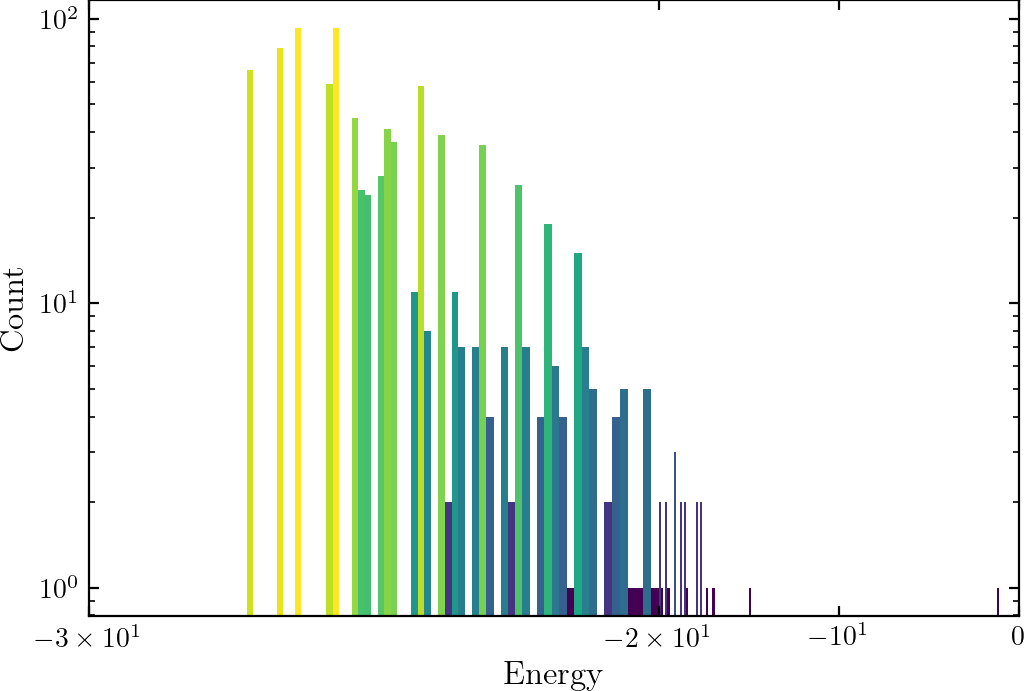

In [30]:
# Solution histogram

plt.figure(figsize=(6,4))
N, bins, patches = plt.hist(df["energy"], bins=500, log=True)

norm = mpl.colors.LogNorm(1, N.max())
for thisfrac, thispatch in zip(N, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel("Energy")
plt.ylabel("Count")
plt.xscale("symlog", linthresh=20, linscale=0.1)
plt.xlim(-30,0)
plt.xticks([-30,-20,-10,0])
#plt.savefig("..\Figures\histogram.pdf", pad_inches=0, bbox_inches="tight")

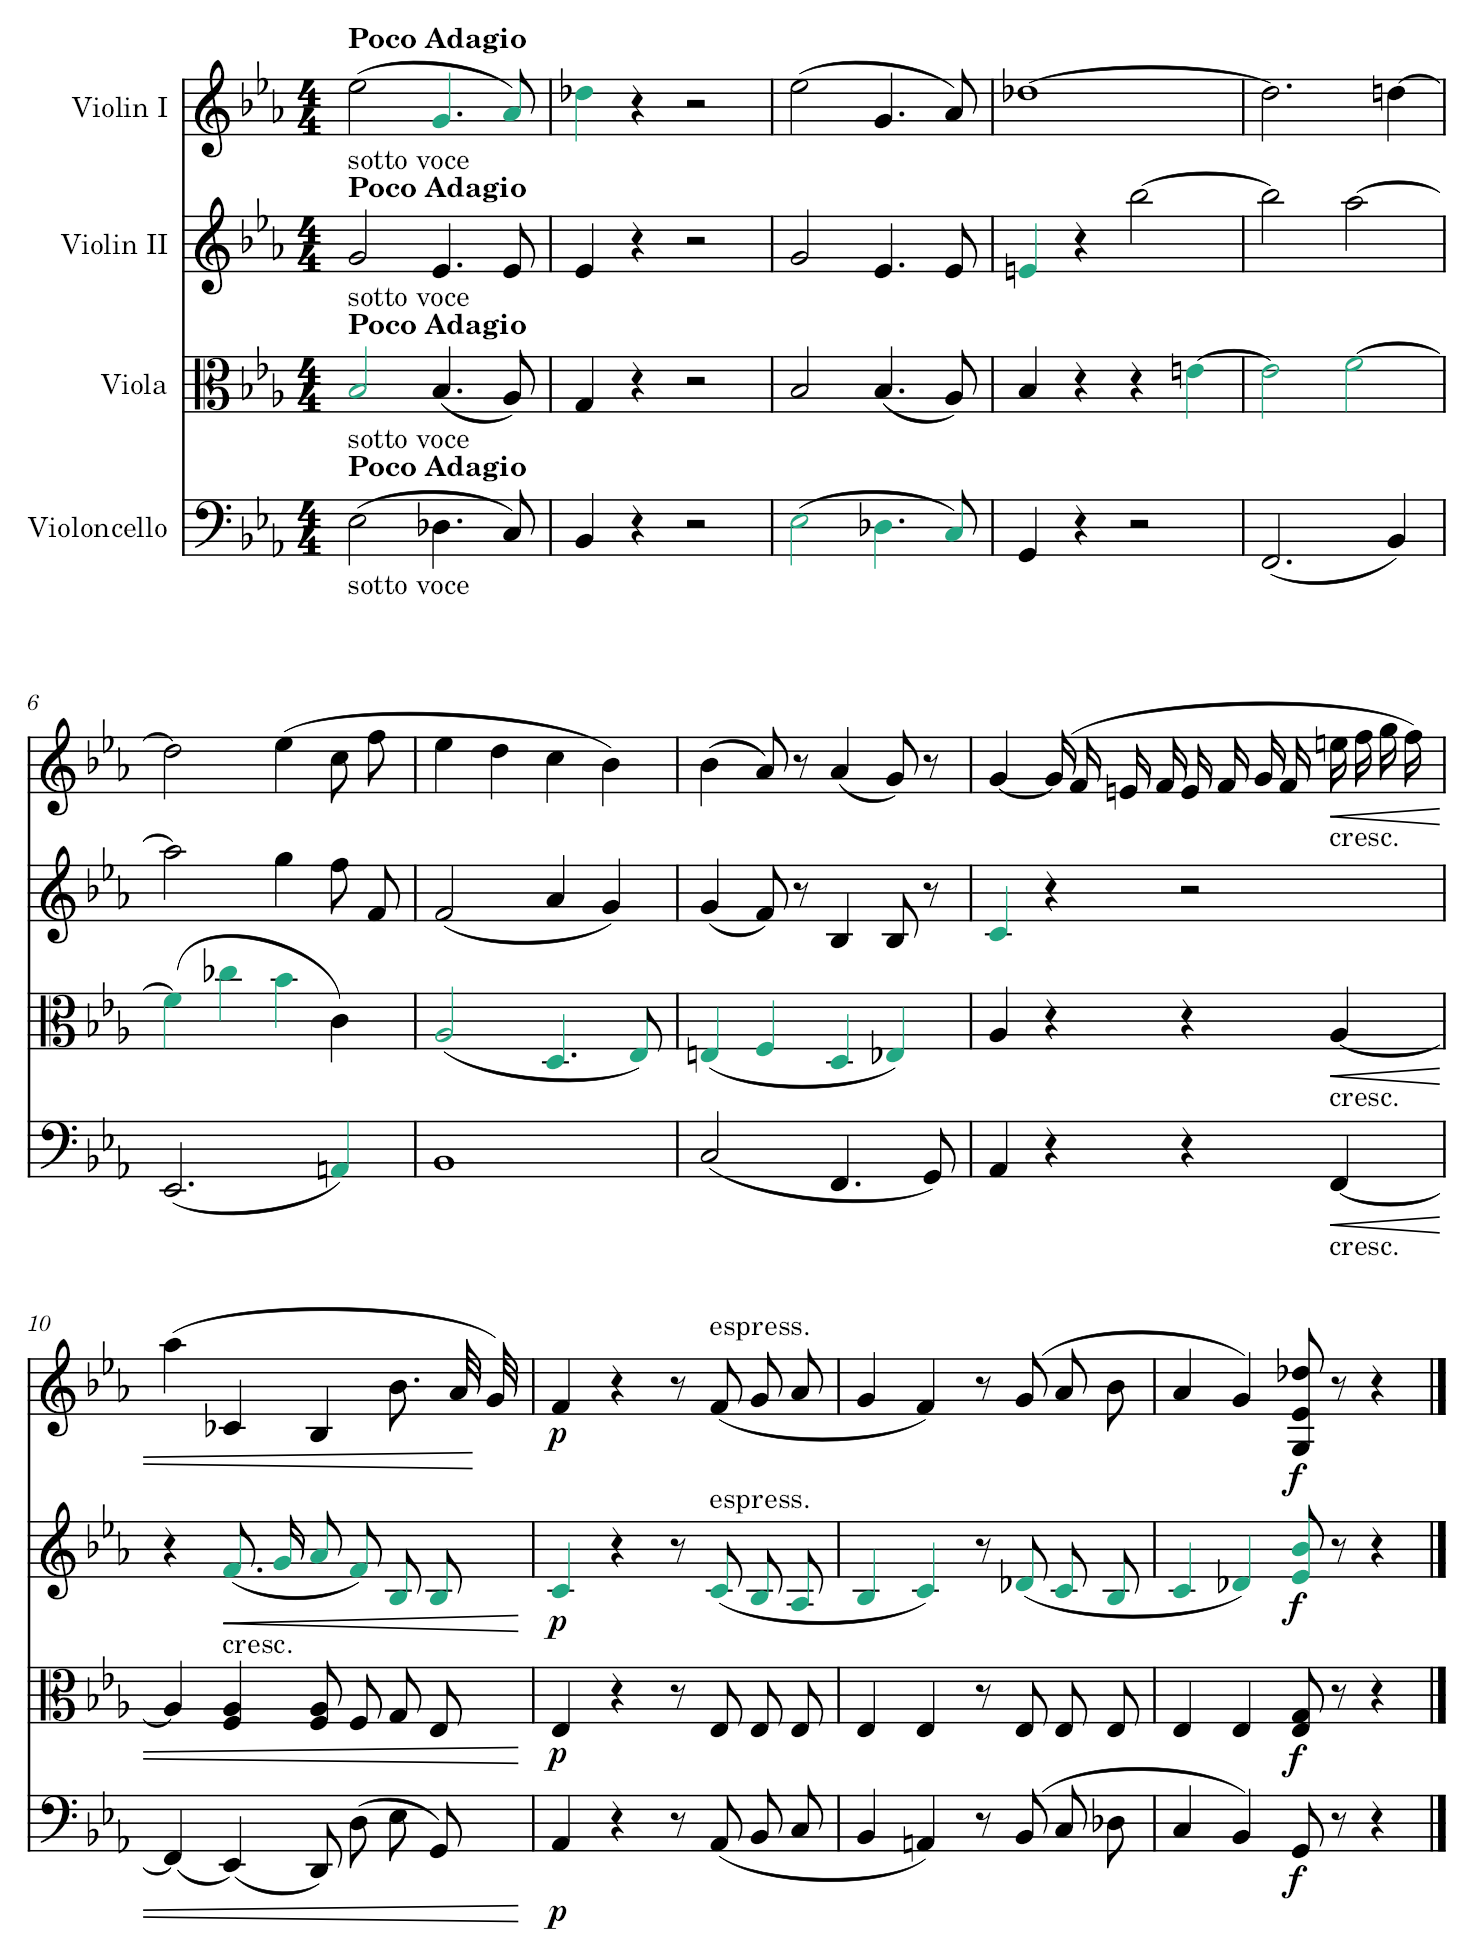

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/selected-1.png')

In [8]:
# Colour selected phrases

phraseStack = pickle.load(open(f"../Pickles/{identifier}_phraseStack.pkl", "rb"))
selected = stream.Score()

for part in phraseStack:
    newPart = stream.Part()
    selected.insert(0,newPart)

    for phrase in part:
        newPart.mergeElements(phrase)
        
        if phrase.id in chosen:
            for el in phrase.notes:
                el.style.color = V.TURQUOISE.value   

selected.show(leaveMargin=50)
selected.write(fmt="musicxml.png", fp="../Figures/selected_trim.png", dpi=300)
selected.write(fmt="musicxml.png", fp="../Figures/selected.png", dpi=300, leaveMargin=50)

In [ ]:
# Remove all except selected

selected = stream.Score()

for i,part in enumerate(phraseStack):
    newPart = stream.Part()
    selected.insert(0,newPart)

    for phrase in part:
        if phrase.id in chosen:
            newPart.mergeElements(phrase)

    if newPart.getInstrument(returnDefault=False) is None:
        newPart.insert(0, part[0].getInstrument())
        newPart.insert(0, part[0].getElementsByClass(key.Key)[0])
        newPart.insert(0, part[0].getTimeSignatures()[0])

selected.show()
#selected.write(fmt="musicxml.png", fp="../Figures/selected.png", dpi=300)

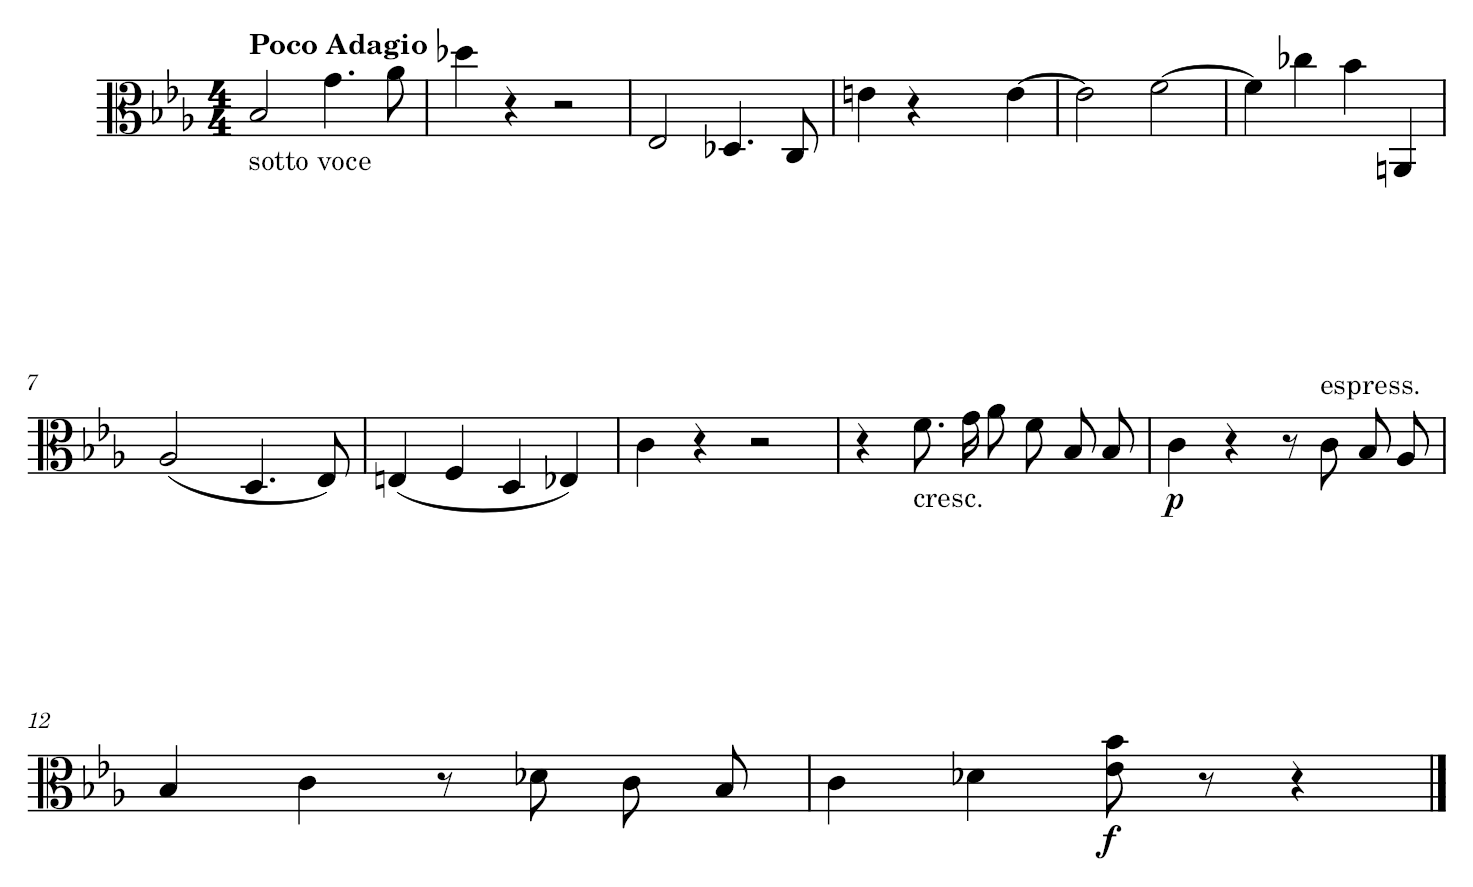

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/arrangement-1.png')

In [10]:
# Final arrangement

arrangement = stream.Stream()

for phrase in flatStack:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

arrangement.show(leaveMargin=50)
arrangement.write(fmt="musicxml.png", fp="../Figures/arrangement_trim.png", dpi=300)
arrangement.write(fmt="musicxml.png", fp="../Figures/arrangement.png", dpi=300, leaveMargin=50)

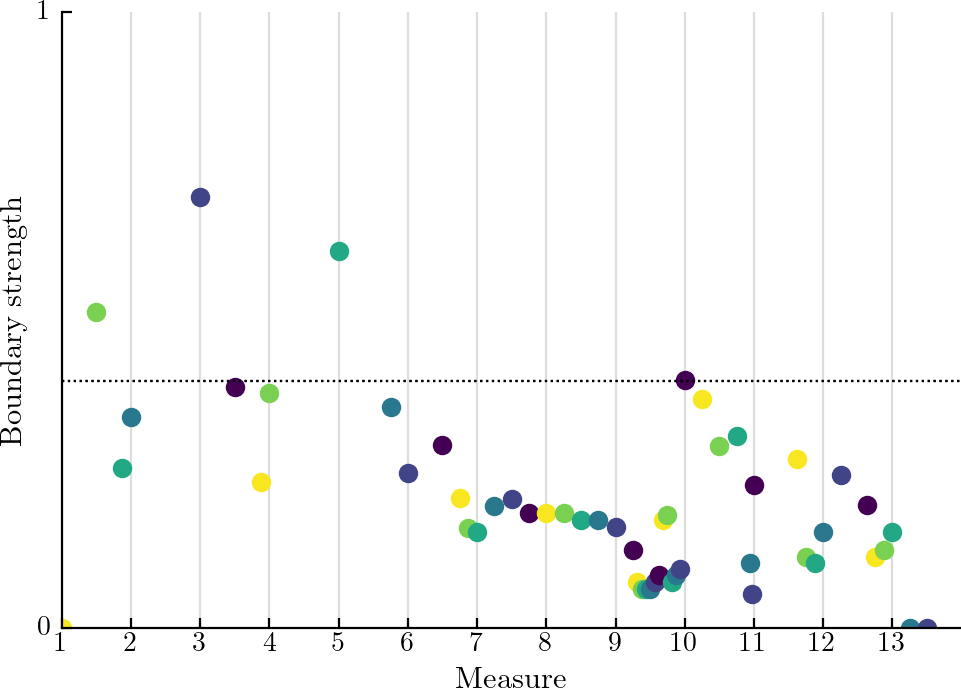

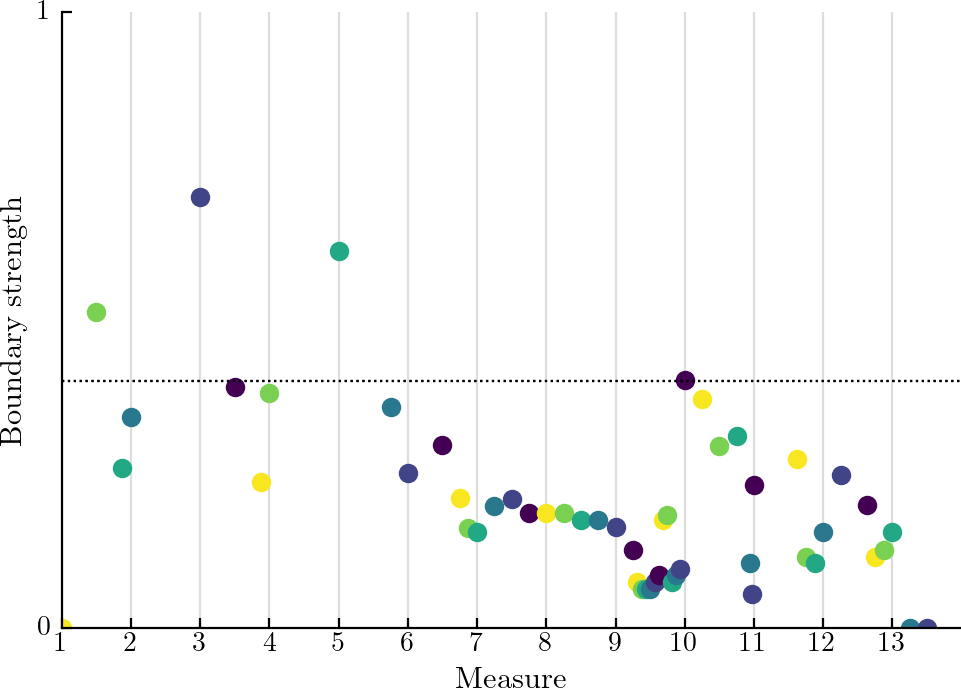

In [6]:
# Boundary strength

class BoundaryStrengthAxis(graph.axis.Axis):
    labelDefault = 'Boundary strength'

    def __init__(self, client=None, axisName='y'):
        super().__init__(client, axisName)
        self.minValue = 0
        self.maxValue = 1

    def ticks(self):
        ticks = super().ticks()
        tickValues = [0,1]
        newTicks = [(0,0), (1,1)]
        return newTicks

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'boundaryStrength'):
            return el.boundaryStrength

viola = excerpt.parts[0]
boundaries = identifyBoundaries(viola, 0.4)

plotS = graph.plot.Scatter(viola, marker="o")

plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = BoundaryStrengthAxis(plotS, 'y')
plotS.title = ""
plotS.figureSize = (6,4)

plotS.alpha = 1
plotS.colors = [c.value for c in V]
plotS.labelFontSize = 11
plotS.tickFontSize = 10
plotS.doneAction = None
plotS.axisX.label = "Measure"
plotS.hideYGrid = True

plotS.run()

line = plt.hlines(0.4, 0, viola.quarterLength, linestyles=":", colors="black")
plotS.subplot.add_artist(line)
plotS.subplot.set_xlim(left=0, right=viola.quarterLength)
plotS.subplot.set_ylim(bottom=0, top=1)

#plotS.write()
#plotS.write(fp="..\\Figures\\boundary_offset.pdf")

In [ ]:
# Generate LaTeX table for phrase properties

table = pd.DataFrame(columns=["Measure", "Boundary strength", "Entropy"])

for p in phraseStack[0]:
    table.loc[len(table)] = [p[0].offset, p.notes[0].boundaryStrength, p.entropy]

table.head()
print(table.to_latex())

In [ ]:
'''
class EntropyAxis(graph.axis.Axis):
    labelDefault = 'Entropy'

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'name'):
            return noteEntropy(el)
        
plotS = graph.plot.Scatter(excerpt.parts[0])

plotS.title = 'Offset vs Entropy'
plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = EntropyAxis(plotS, 'y')

plotS.run()
'''